# **Adaptive RAG**

[Link to the paper](https://arxiv.org/abs/2403.14403)

**Architecture**:

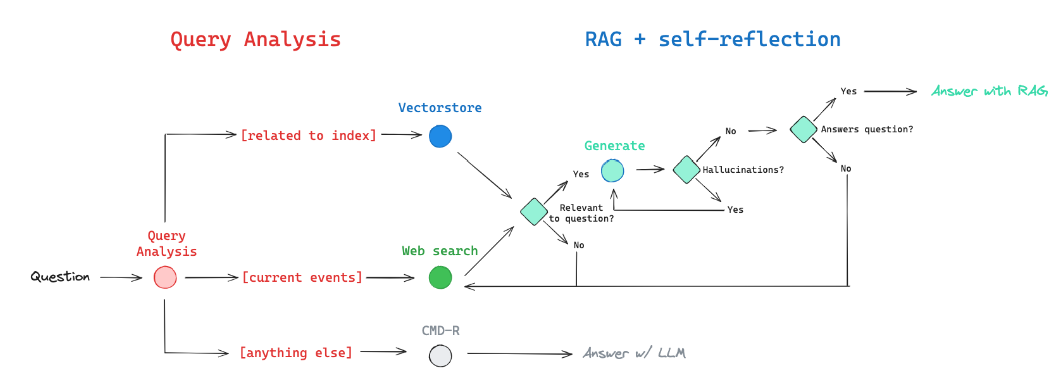
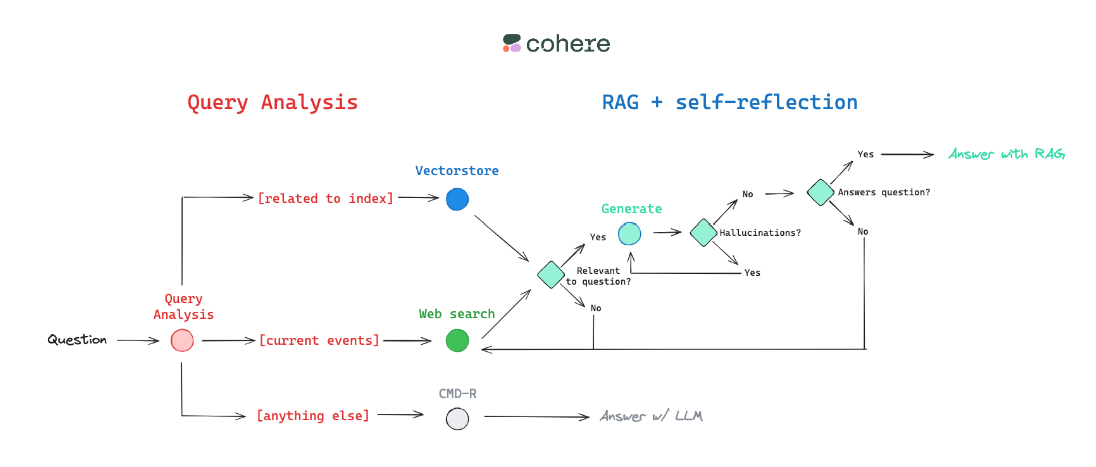

So the story now is that I have an application that I can interact with. The only knowledge my application has access to is the information in the PDFs I upload to its database. Maybe in some instance, there will be need for a piece of information that is related to the knowledge base but not in the PDF therefore not present in the knowledgebase. Agentic RAG techniques are used to equip the generator LLM with more abilities including access to foreign knowledge. 


You can clearly begin to see the flexibility. With chains, it's prebuilt functions, and you cannot really alter them to your taste. Adaptive RAG encourages an algorithmic building of your application so that a developer can have more flexibility in building.
So instead of if-the-user-input-is-this-then-always-go-to-our-database *hard-coded*, the flexibility comes in if-the-user-input-is-this-then-go-to-our-database-else-then-try-this-other-knowledgebase. It then becomes algorithmic, with conditional statements, and active states, etc. Therefore, chains will become less helpful. As such, Adaptive RAG techniques are built using knowledge graphs. Fortunately, langchain has a library called [**LangGraph**](https://python.langchain.com/v0.1/docs/langgraph/). 



I will be using LangGraph for this implementation. I will also use a free public API for searching the internet, as a tool for my chatbot. You can find out about [**Tavily Search API**](https://python.langchain.com/v0.1/docs/integrations/retrievers/tavily/).
This is not very perfect for my use case - it kind of defeats the purpose if I present my chatbot with external knowledge. However, I just want to keep going on and on about RAG. I love the technique. 






Anywho, I will modify my goal, to accomodate Adaptive RAG, and use my chatbot to also ask about stuff that can be found on the internet like *what day of the week is it?* or *which club did Messi last score against?* Fun stuff!

Before I begin, load environment keys:

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

I will observe queries and responses using Langchain's observability tool: [**Langsmith**](https://docs.smith.langchain.com/old). Make sure your LANGCHAIN_API_KEY has been sent to the environment.

In [2]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"Blaq's PDF Chatbot - {unique_id}"

----------------------------------------


In [4]:
# Download PDF file
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


My pipeline:

In [2]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want

# **Advanced RAG**

# Defining Components

Router:

Helps my application decide whether to use the existing knowledgebase or to query the internet to answer the user question.

I will be using a locally managed model via [**Ollama**](https://ollama.com/). Kindly follow the link if you do not know how to set up Ollama on your local machine. 

I will be using the llama2 model.

In [3]:
question = "who are you?"
docs = retriever.get_relevant_documents(question)
print(docs[1])

c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


page_content='Introduction  |  11' metadata={'source': 'human-nutrition-text.pdf', 'file_path': 'human-nutrition-text.pdf', 'page': 52, 'total_pages': 1208, 'format': 'PDF 1.7', 'title': 'Human Nutrition: 2020 Edition', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Pressbooks 5.9.2', 'producer': 'Prince 12.5 (www.princexml.com)', 'creationDate': '', 'modDate': '', 'trapped': ''}


In [5]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model="llama2", format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are an expert at routing user questions to the appropriate data source. Based on the provided question, please classify it into one of the following categories:

vectorstore: Questions related to human nutrition. 
classified: Questions that do not require up-to-date information and are also not based on human nutrition, such as questions about the emotional state of the chatbot, personal inquiries, or intimate requests.
web_search: Questions that require up-to-date information and could be related to human nutrition.

Reply with a JSON object containing a single key 'datasource'. Only reply with each classification such as 'vectorstore','classified', or 'web_search'. Please no preamble or explanation.

Question: {question}

JSON Response: """,
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "Who is Neymar?"
print(question_router.invoke({"question": question}))

{'datasource': 'web_search'}


Relevancy Grader/Retrieval Grader:

A component to grade the relevance of the retrieved documents to the user query.

In [6]:
### Retrieval Grader 

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model="codegemma:2b", format="json", temperature=0)

grader_prompt = PromptTemplate(
    template="""You are a grader assessing the relevance of a retrieved document to a user question.

Here is the retrieved document:

{document}

Here is the user question:

{question}

To assess the relevance of the document to the question, please use semantic similarity to compare the meaning of the document and the question. If the document contains information that is semantically similar to the user question, grade it as relevant. Do not be stringent with the keywords. The goal is to filter out erroneous retrievals.

Give a binary score 'yes' to indicate that the document is relevant to the question, or 'no' to indicate that the document is NOT relelvant to the question .

Provide the binary score as a JSON object with a single key 'score' and no preamble or explanation.

JSON Response:""",
    input_variables=["question", "document"],
)

retrieval_grader = grader_prompt | llm | JsonOutputParser()
question = "what are memory agents?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


Generator:

For responding to the user query.

In [7]:
### Generate

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""Answer the following question based only on the provided context. 
Question: {question}
Context: {documents}""",
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model="llama2", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What are macronutrients?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)


Macronutrients are nutrients that are needed in large amounts and include carbohydrates, lipids, and proteins. These macronutrients can be metabolically processed into cellular energy through chemical bonds, which provides the energy for our bodies to perform basic functions.


Hallucination Grader:

To test for llm hallucination.

In [8]:
### Hallucination Grader 

# LLM
llm = ChatOllama(model="llama2", format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
docs = retriever.invoke(question)
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

Response Grader:


Grade the relevance of the generator's response to the user query.

In [9]:
### Answer Grader 

# LLM
llm = ChatOllama(model="llama2", format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question,"generation": generation})

{'score': 'yes'}

Query Re-writer:

To restructure the query for easy retrieval.

In [10]:
### Question Re-writer

# LLM
llm = ChatOllama(model="llama2", temperature=0)

# Prompt 
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized 
     for vectorstore retrieval. Look at the initial and formulate an improved question. 
     Here is the initial question:  {question}. 
     Revised question:  
     Please no preamble or extra sentences just the revised question will suffice.""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'\nRevised question: What are the main macronutrients found in food and their functions in the human body?'

Substitute LLM / Fallback:



A substitute generator using its pretrained knowledge to try to answer user query without ID for 'tool_calls'. This will be particularly useful for queries like: *Hi, how are you?* . This will be used to tackle the issue of a *guided* response.

In [11]:
### LLM fallback

# LLM
llm = ChatOllama(model="llama2", temperature=0)

# Prompt 
substitute_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. Answer the following question only with this reply - Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to discuss about me. 
    Question:  {question}. 
    Your reply:  Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to discuss about me 
    Please no preamble or extra sentences just that same reply.""",
    input_variables=["question"],
)

rag_chain2 = substitute_prompt | llm | StrOutputParser()
# Run
question = "Hi how are you?"
generation2 = rag_chain2.invoke({"question": question})
print(generation2)

Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to discuss about me.


### Web Search Tool

To gain access to this API as a tool, you need an API key. Get it [here](https://app.tavily.com/home).

In [ ]:
# uncomment and run code if you do not have tavily package installed already.
# !pip install -qU tavily-python

In [12]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Provide your Tavily Search Api Key here: ")
  print("TAVILY_API_KEY successfully sent to the environment")

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

### Graph
Capture the Adaptive RAG architecture as a control workflow using LangGraph.

I will define the state of the graph as a class.

In [14]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question : str
    generation : str
    documents : List[str]

In [19]:
### Nodes

from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("Retrieving...")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("Generating response...")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("Checking Document's relevance to query...")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        if grade == "yes":
            print("GRADE: Document relevant")
            filtered_docs.append(d)
        else:
            print("GRADE: Document NOT relevant")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("Re-writing user query...")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def llm_fallback(state):
    """
    Generate answer using the substitute LLM
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation2, that contains substitute llm responses
    """
    print("Substitute LLM.")
    question = state["question"]
    generation2 = rag_chain2.invoke({"question": question})
    return {"question": question, "generation": generation2}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("Searching the internet...")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges ###

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("Routing query...")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("Routing query to the web search tool...")
        return "web_search"
    elif source['datasource'] == 'vectorstore':
        print("Routing query to vector database...")
        return "vectorstore"
    print("Routing query to substitute LLM...")  # if datasource = 'classified'
    return "llm_fallback"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("Assessing Graded documents...")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("DECISION: Retrieved documents are NOT relevant to query, so re-writing user query...")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("DECISION: Responding to user query...")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("Checking for hallucination...")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("DECISION: Response is grounded. No hallucination.")
        # Check question-answering
        print("Grading relevancy to user query...")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("DECISION: Response is relevant to user query.")
            return "useful"
        else:
            print("DECISION: Response DOES NOT address user query.")
            return "not useful"
    else:
        pprint("DECISION: Response is NOT grounded with knowledge base. Ending...")
        return "not supported"

Now compiling the flow chart.

In [20]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # llm
workflow.add_node("transform_query", transform_query) # transform_query
workflow.add_node("llm_fallback", llm_fallback) # substitute llm

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("llm_fallback", END)
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "transform_query",
        "not useful": "web_search",
        "useful": END,
    },
)

# Compile
app = workflow.compile()

In [28]:
from pprint import pprint

# Run 
inputs = {"question": "What is the database about?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

Routing query...
What is the database about?


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'datasource': 'vectorstore'}
vectorstore
Routing query to vector database...
Retrieving...
"Node 'retrieve':"
'\n---\n'
Checking Document's relevance to query...
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
GRADE: Document relevant
Assessing Graded documents...
DECISION: Responding to user query...
"Node 'grade_documents':"
'\n---\n'
Responding from knowledge base...
Checking for hallucination...
DECISION: Response is grounded. No hallucination.
Grading relevancy to user query...


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


DECISION: Response is relevant to user query.
"Node 'generate':"
'\n---\n'
('\n'
 'Based on the provided context, it appears that the database is related to '
 'human nutrition and health. The documents provide information on various '
 'topics such as:\n'
 '\n'
 '1. The importance of nutrition in overall health and wellness\n'
 "2. How to find a healthy diet that suits an individual's needs and goals\n"
 '3. Understanding the different types of nutrients and their roles in the '
 'body\n'
 '4. The benefits of exercise and physical activity for overall health\n'
 '5. How to use a smart fridge to track daily diet and receive weekly '
 'assessments\n'
 '6. The structure of the breast and how milk is produced\n'
 '7. Introduction to human nutrition and its importance\n'
 '8. Acknowledgements of internal and extra-text links to videos and web '
 'material.\n'
 '\n'
 'Therefore, the database appears to be focused on providing information and '
 'resources related to human nutrition and heal

In [17]:
# Run
from pprint import pprint

inputs = {"question": "Where is Nigeria?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value ["generation"])

Routing query...
Where is Nigeria?
{'datasource': 'web_search'}
web_search
Routing query to the web search tool...
Searching the internet...
"Node 'web_search':"
'\n---\n'
Generating response...
Checking for hallucination...
DECISION: Response is grounded. No hallucination.
Grading relevancy to user query...
DECISION: Response is relevant to user query.
"Node 'generate':"
'\n---\n'
('Nigeria is a country located in West Africa, bordered by several countries '
 'including Benin, Chad, Cameroon, and Niger. It has a diverse geography, with '
 "savannas, forests, and mangrove swamps in different regions. The country's "
 'climate is also varied, with a rainy season that lasts from April to '
 'September and a dry season from December to February.\n'
 '\n'
 'Nigeria has a population of over 200 million people, making it the most '
 'populous country in Africa. The official language is English, but there are '
 'over 500 languages spoken in the country. The capital city is Abuja, while '
 'L

In [18]:
# Run
from pprint import pprint

inputs = {"question": "Who are you?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value ["generation"])

Routing query...
Who are you?
{'datasource': 'classified'}
classified
Routing query to substitute LLM...
Substitute LLM.
"Node 'llm_fallback':"
'\n---\n'
('\n'
 'Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to discuss '
 'about me.')


This is how you can implement Adaptive RAG with local LLMs. 


It did not perform too badly, but clearly it underperformed compared to the performance of Cohere models in the other Adaptive RAG notebook - *adaptive_rag.ipynb*.